<a href="https://www.kaggle.com/code/loopedward/forecast-your-site-visits?scriptVersionId=142060486" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data Ingest

In [1]:
import pandas as pd

FILE_LOCATION = '/kaggle/input/daily-website-visitors/daily-website-visitors.csv'

whole_dataset = pd.read_csv(FILE_LOCATION, 
                            index_col='Date',
                            thousands=',')
whole_dataset.index = pd.to_datetime(whole_dataset.index)
whole_dataset

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,2146,1582,1430,152
2014-09-15,2,Monday,2,3621,2528,2297,231
2014-09-16,3,Tuesday,3,3698,2630,2352,278
2014-09-17,4,Wednesday,4,3667,2614,2327,287
2014-09-18,5,Thursday,5,3316,2366,2130,236
...,...,...,...,...,...,...,...
2020-08-15,2163,Saturday,7,2221,1696,1373,323
2020-08-16,2164,Sunday,1,2724,2037,1686,351
2020-08-17,2165,Monday,2,3456,2638,2181,457


In [2]:
whole_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2167 entries, 2014-09-14 to 2020-08-19
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Page.Loads         2167 non-null   int64 
 4   Unique.Visits      2167 non-null   int64 
 5   First.Time.Visits  2167 non-null   int64 
 6   Returning.Visits   2167 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 135.4+ KB


In [3]:
whole_dataset.describe()

,Row,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
count,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000
mean,1084.000000,3.997231,4116.989386,2943.646516,2431.824181,511.822335
std,625.703338,2.000229,1350.977843,977.886472,828.704688,168.736370
min,1.000000,1.000000,1002.000000,667.000000,522.000000,133.000000
25%,542.500000,2.000000,3114.500000,2226.000000,1830.000000,388.500000
50%,1084.000000,4.000000,4106.000000,2914.000000,2400.000000,509.000000
75%,1625.500000,6.000000,5020.500000,3667.500000,3038.000000,626.500000
max,2167.000000,7.000000,7984.000000,5541.000000,4616.000000,1036.000000


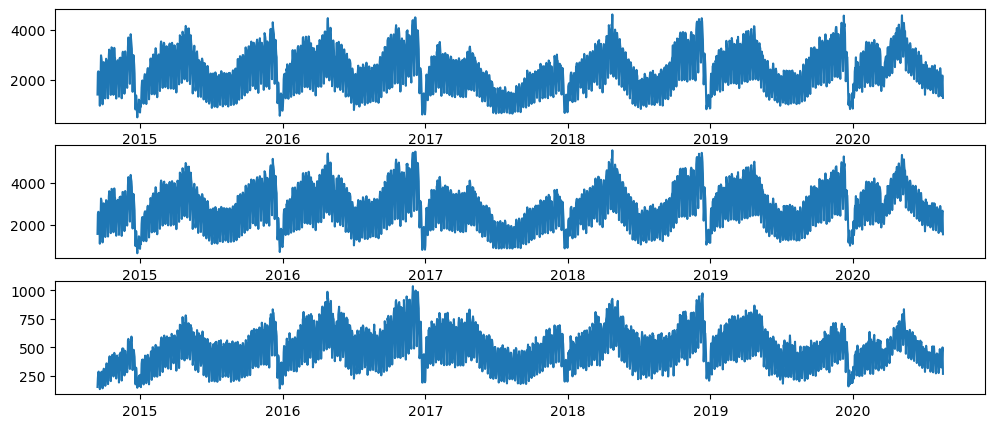

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(12, 5))

axs[0].plot(whole_dataset['First.Time.Visits'])
axs[1].plot(whole_dataset['Unique.Visits'])
axs[2].plot(whole_dataset['Returning.Visits'])
plt.show()

# Preprocessing the data

* Target Attribute: **Returning.Visits** 
We shall predict the **Returning.Visits** given past data.


In [5]:
target_column = whole_dataset['Returning.Visits']
target_column

Date
2014-09-14    152
2014-09-15    231
2014-09-16    278
2014-09-17    287
2014-09-18    236
             ... 
2020-08-15    323
2020-08-16    351
2020-08-17    457
2020-08-18    499
2020-08-19    267
Name: Returning.Visits, Length: 2167, dtype: int64

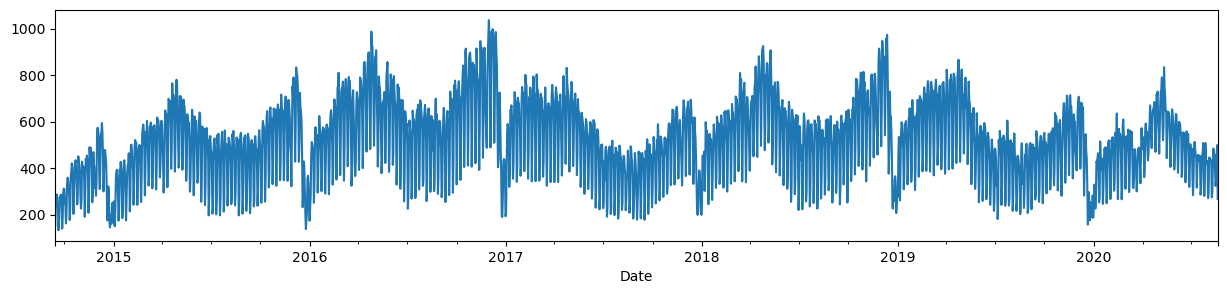

In [6]:
target_column.plot(figsize=(15, 3))
plt.show()

# Compute Train and Test Data Boundaries

In [7]:
len(target_column)

2167

In [8]:
TEST_DATA_PERCENTAGE = 0.1

TEST_DATA_BOUNDARY_INDEX = int((1 - TEST_DATA_PERCENTAGE) * len(target_column))
print(f"Train data:\tReturning Visits [:{TEST_DATA_BOUNDARY_INDEX}] ({TEST_DATA_BOUNDARY_INDEX + 1})")
print(f"Test data:\tReturning Visits [{TEST_DATA_BOUNDARY_INDEX}:] ({len(target_column) - TEST_DATA_BOUNDARY_INDEX})")
print(f"\nLast target on train data: {target_column[TEST_DATA_BOUNDARY_INDEX]}")

Train data:	Returning Visits [:1950] (1951)
Test data:	Returning Visits [1950:] (217)

Last target on train data: 441


In [9]:
print(f"Train dataset ending values: {target_column[TEST_DATA_BOUNDARY_INDEX - 10: TEST_DATA_BOUNDARY_INDEX].values}")
print(f"Test dataset starting values: {target_column[TEST_DATA_BOUNDARY_INDEX: TEST_DATA_BOUNDARY_INDEX + 10].values}")

Train dataset ending values: [429 423 442 464 372 253 277 515 434 394]
Test dataset starting values: [441 413 246 314 443 484 473 490 353 249]


## Window-ize the dataset

In [10]:
from tensorflow.keras.utils import timeseries_dataset_from_array

WINDOW_SIZE = 3
train_dataset = timeseries_dataset_from_array(target_column[:-WINDOW_SIZE], 
                                                 target_column[WINDOW_SIZE:], 
                                                 sequence_length=WINDOW_SIZE,
                                                 end_index=TEST_DATA_BOUNDARY_INDEX - 1)
len(train_dataset), len(list(train_dataset.unbatch()))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

(16, 1947)

In [11]:
target_column[TEST_DATA_BOUNDARY_INDEX-10:TEST_DATA_BOUNDARY_INDEX+10].values, (list(train_dataset)[-1][0][-1].numpy(), list(train_dataset)[-1][1][-1].numpy())

(array([429, 423, 442, 464, 372, 253, 277, 515, 434, 394, 441, 413, 246,
        314, 443, 484, 473, 490, 353, 249]),
 (array([277, 515, 434]), 394))

In [12]:
test_dataset = timeseries_dataset_from_array(target_column[TEST_DATA_BOUNDARY_INDEX - WINDOW_SIZE:], 
                                                 target_column[TEST_DATA_BOUNDARY_INDEX:], 
                                                 sequence_length=WINDOW_SIZE
                                            )
len(test_dataset), len(list(test_dataset.unbatch()))

(2, 217)

In [13]:
target_column[TEST_DATA_BOUNDARY_INDEX-10:TEST_DATA_BOUNDARY_INDEX+10].values, list(test_dataset)[0][0][0].numpy(), list(test_dataset)[0][1][0].numpy()

(array([429, 423, 442, 464, 372, 253, 277, 515, 434, 394, 441, 413, 246,
        314, 443, 484, 473, 490, 353, 249]),
 array([515, 434, 394]),
 441)

In [14]:
# First point in test dataset
list(test_dataset)[0][0][0].numpy(), list(test_dataset)[0][1][0].numpy()

(array([515, 434, 394]), 441)

In [15]:
# Last point in test dataset
list(test_dataset)[-1][0][-1].numpy(), list(test_dataset)[-1][1][-1].numpy()

(array([351, 457, 499]), 267)

## Plot the train and test datasets

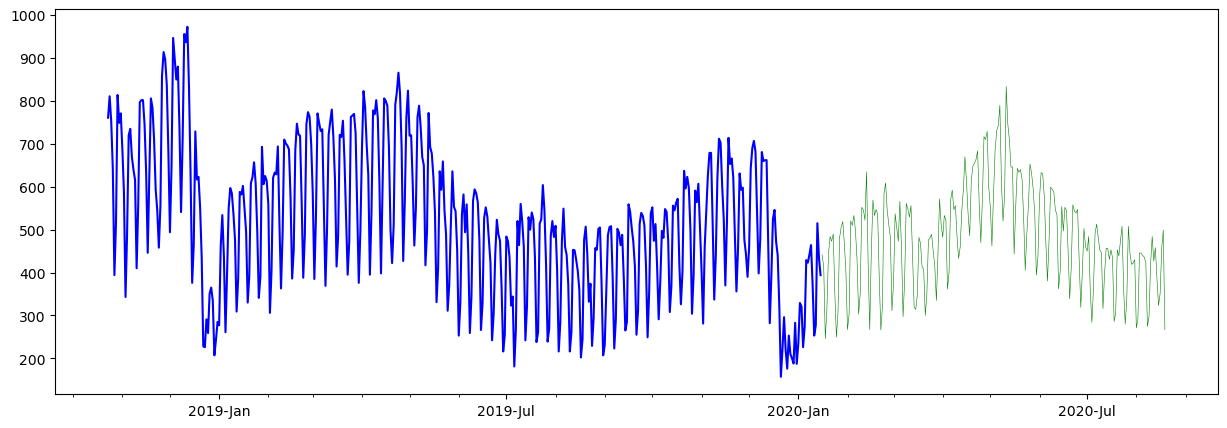

In [16]:
import numpy as np 
import matplotlib.dates as mdates

def plot_time_series(predictions = None, start_index=1500):
    timesteps = pd.to_datetime(target_column.index)
    
    fig,ax = plt.subplots(1,figsize=(15,5))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    
    # Plot train dataset
    plt.plot(timesteps[start_index:TEST_DATA_BOUNDARY_INDEX], target_column[start_index:TEST_DATA_BOUNDARY_INDEX],
            color='blue')
    # Plot test dataset
    plt.plot(timesteps[TEST_DATA_BOUNDARY_INDEX:], target_column[TEST_DATA_BOUNDARY_INDEX:],
             color='green', linewidth=0.4)
    
    if predictions is not None:
        pred_timesteps = timesteps[TEST_DATA_BOUNDARY_INDEX:]
        plt.plot(pred_timesteps, predictions, linewidth=0.4, color='red')
        plt.scatter(pred_timesteps, predictions, s=0.4, color='red')

        
plot_time_series()

# Model 0: Baseline model

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model

class NaiveForecastLayer(Model):
    def __init__(self):
        super().__init__()
        
    def call(self, inputs):
        result = inputs[:, -1]
        return result[:, tf.newaxis]


In [18]:
baseline_model = NaiveForecastLayer()
baseline_model._name = 'model_0'

baseline_model.compile(metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [19]:
baseline_predictions = baseline_model.predict(test_dataset)

2/2 [==============================] - 0s 13ms/step


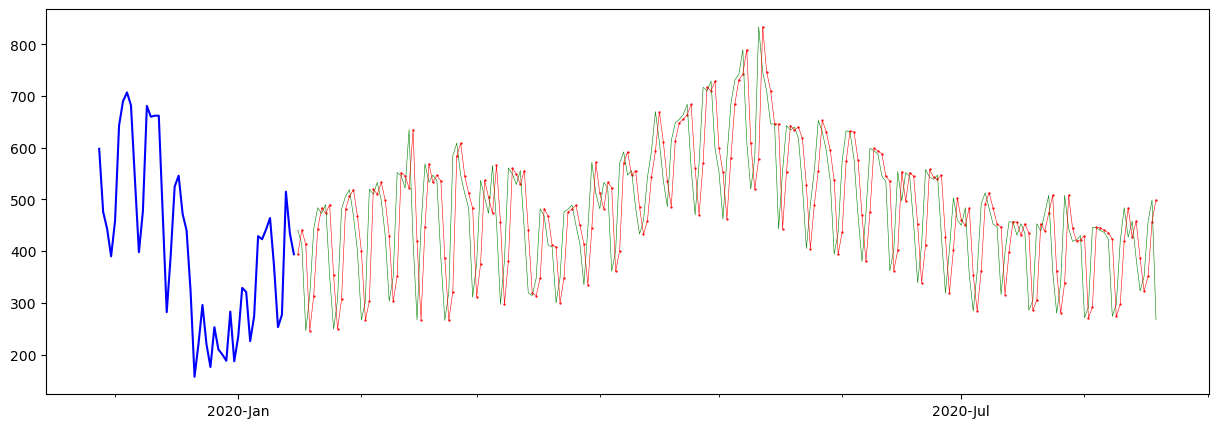

In [20]:
plot_time_series(baseline_predictions.ravel(), start_index=1900)

In [21]:
y_true = target_column[TEST_DATA_BOUNDARY_INDEX : ]

len(y_true), y_true

(217,
 Date
 2020-01-16    441
 2020-01-17    413
 2020-01-18    246
 2020-01-19    314
 2020-01-20    443
              ... 
 2020-08-15    323
 2020-08-16    351
 2020-08-17    457
 2020-08-18    499
 2020-08-19    267
 Name: Returning.Visits, Length: 217, dtype: int64)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_predictions(y_true, y_preds):
    mae = mean_absolute_error(y_true, y_preds)
    mse = mean_squared_error(y_true, y_preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_preds)
    
    return {
        'mae': mae,
        'mse': mse, 
        "rmse": rmse,
        "mape": mape
    }

evaluate_predictions(y_true, baseline_predictions)

{'mae': 72.19815668202764,
 'mse': 8508.622119815669,
 'rmse': 92.24219273096054,
 'mape': 0.16713927858326993}

In [23]:
MODEL_METRICS = pd.DataFrame(columns=['mae', 'mse', 'rmse', 'mape'])

def evaluate_model(model):
    predictions = model.predict(test_dataset, verbose=0)
    metrics = evaluate_predictions(y_true, predictions)
    
    MODEL_METRICS.loc[model.name] = metrics
    plot_time_series(predictions.ravel(), start_index=1900)
    return metrics


{'mae': 72.19815668202764,
 'mse': 8508.622119815669,
 'rmse': 92.24219273096054,
 'mape': 0.16713927858326993}

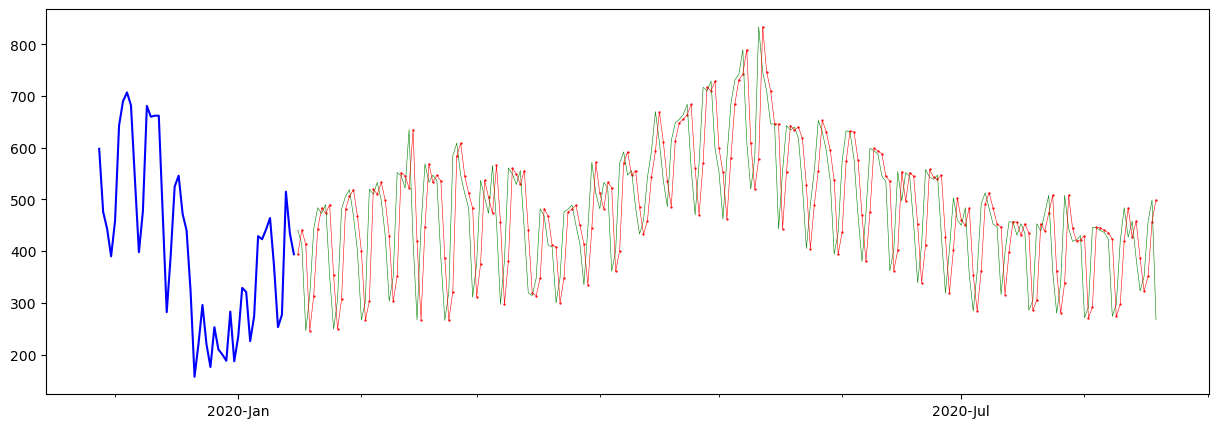

In [24]:
evaluate_model(baseline_model)

In [25]:
MODEL_METRICS

,mae,mse,rmse,mape
model_0,72.198157,8508.62212,92.242193,0.167139


# Model 1: Recurrent Network Model (GRU)

In [26]:
from tensorflow.keras.layers import GRU, Dense, Input, Lambda
from tensorflow.keras import Sequential

tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape=(WINDOW_SIZE,)),
    Lambda(lambda x: tf.expand_dims(x, axis=1)),
    GRU(128, activation="relu"),
    Dense(1)
], name='model_1')

model_1.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 3)              0         
                                                                 
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

def create_checkpoint_callback(model):
    filepath = os.path.join('models', model.name)
    return ModelCheckpoint(filepath, monitor='loss', save_weights_only=True, save_best_only=True)

model_1.fit(train_dataset, epochs=5, callbacks=[ create_checkpoint_callback(model_1) ])

Epoch 1/5
16/16 [==============================] - 6s 23ms/step - loss: 434.3134
Epoch 2/5
16/16 [==============================] - 0s 22ms/step - loss: 231.5194
Epoch 3/5
16/16 [==============================] - 0s 22ms/step - loss: 131.5156
Epoch 4/5
16/16 [==============================] - 0s 22ms/step - loss: 120.6824
Epoch 5/5
16/16 [==============================] - 0s 23ms/step - loss: 109.5811


{'mae': 75.97736101985527,
 'mse': 9384.529501460089,
 'rmse': 96.8737812901927,
 'mape': 0.16859899052082924}

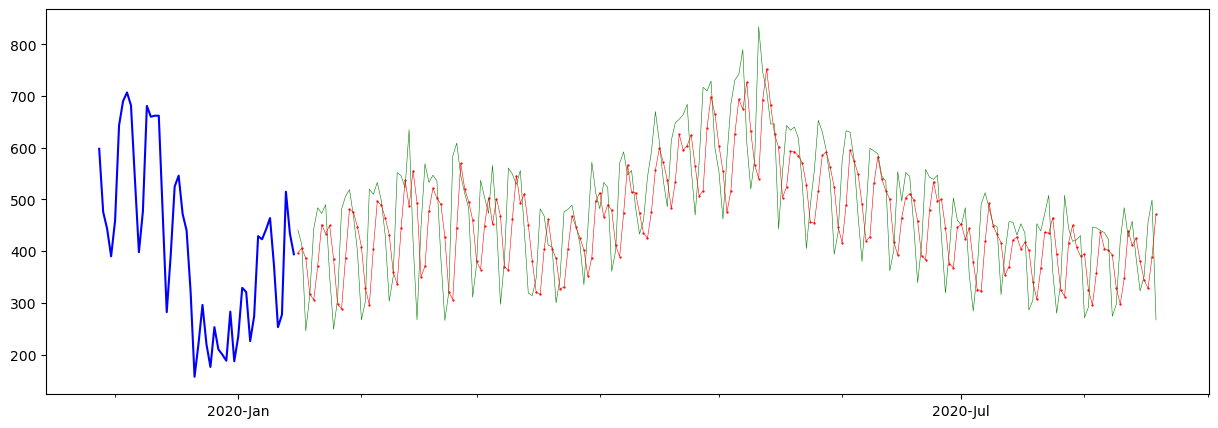

In [28]:
evaluate_model(model_1)

In [29]:
MODEL_METRICS

,mae,mse,rmse,mape
model_0,72.198157,8508.622120,92.242193,0.167139
model_1,75.977361,9384.529501,96.873781,0.168599


# Model 3: Multi-input Model

In [30]:
unbatched_train_dataset = whole_dataset[:TEST_DATA_BOUNDARY_INDEX + 1].copy()
unbatched_train_dataset

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,2146,1582,1430,152
2014-09-15,2,Monday,2,3621,2528,2297,231
2014-09-16,3,Tuesday,3,3698,2630,2352,278
2014-09-17,4,Wednesday,4,3667,2614,2327,287
2014-09-18,5,Thursday,5,3316,2366,2130,236
...,...,...,...,...,...,...,...
2020-01-12,1947,Sunday,1,2762,2238,1961,277
2020-01-13,1948,Monday,2,4298,3242,2727,515
2020-01-14,1949,Tuesday,3,3838,2884,2450,434


DA: Any significant different per day, per month, per year?

## Per `Day of Week` grouping

In [31]:
dataset_by_day = unbatched_train_dataset.groupby(by=['Day'])
dataset_by_day['Returning.Visits'].mean()

Day
Friday       484.697842
Monday       606.512545
Saturday     306.071942
Sunday       390.573477
Thursday     584.627240
Tuesday      617.888889
Wednesday    614.369176
Name: Returning.Visits, dtype: float64

<Axes: xlabel='Day'>

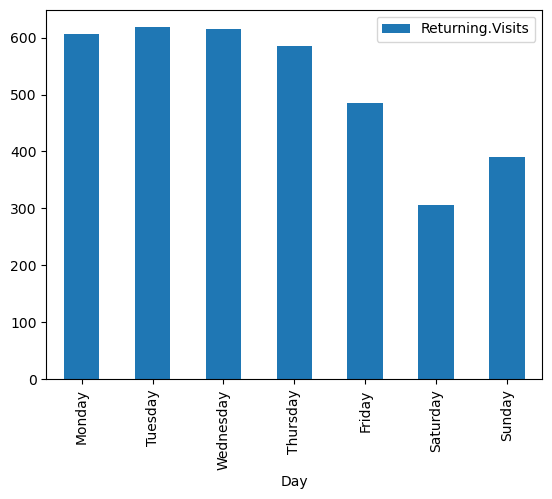

In [32]:
DAYS_OF_WEEK = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pd.DataFrame(dataset_by_day['Returning.Visits'].mean()).loc[DAYS_OF_WEEK].plot(kind='bar')

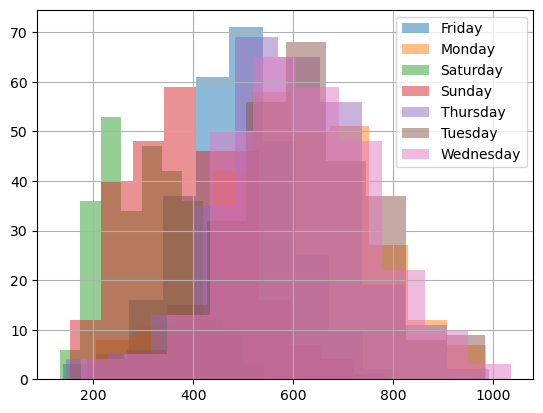

In [33]:
dataset_by_day['Returning.Visits'].hist(legend=True, alpha=0.5)
plt.show()


In [34]:
import calendar

train_dataset_with_months = unbatched_train_dataset.copy()
train_dataset_with_months['Month.Name'] = pd.Series(train_dataset_with_months.index, 
                                                    index=train_dataset_with_months.index)\
                                            .apply(lambda x: calendar.month_name[x.month])
train_dataset_with_months

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month.Name
Date,,,,,,,,
2014-09-14,1,Sunday,1,2146,1582,1430,152,September
2014-09-15,2,Monday,2,3621,2528,2297,231,September
2014-09-16,3,Tuesday,3,3698,2630,2352,278,September
2014-09-17,4,Wednesday,4,3667,2614,2327,287,September
2014-09-18,5,Thursday,5,3316,2366,2130,236,September
...,...,...,...,...,...,...,...,...
2020-01-12,1947,Sunday,1,2762,2238,1961,277,January
2020-01-13,1948,Monday,2,4298,3242,2727,515,January
2020-01-14,1949,Tuesday,3,3838,2884,2450,434,January


In [35]:
MONTH_NAMES = list(calendar.month_name)[1:]
dataset_group_by_month = train_dataset_with_months.groupby(by='Month.Name')
dataset_group_by_month['Returning.Visits'].mean().loc[MONTH_NAMES]

Month.Name
January      445.976608
February     549.354610
March        583.470968
April        651.740000
May          601.135484
June         496.180000
July         438.509677
August       437.522581
September    426.173653
October      509.209677
November     569.716667
December     490.274194
Name: Returning.Visits, dtype: float64

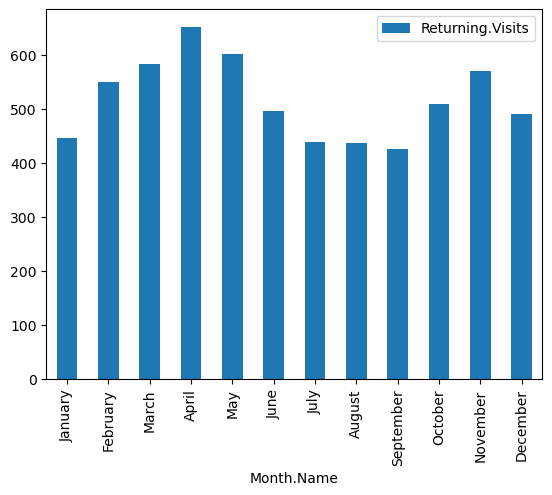

In [36]:
pd.DataFrame(dataset_group_by_month['Returning.Visits'].mean()).loc[MONTH_NAMES].plot(kind='bar')
plt.show()

## Prepare the dataset

In [37]:
train_dataset_with_months

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month.Name
Date,,,,,,,,
2014-09-14,1,Sunday,1,2146,1582,1430,152,September
2014-09-15,2,Monday,2,3621,2528,2297,231,September
2014-09-16,3,Tuesday,3,3698,2630,2352,278,September
2014-09-17,4,Wednesday,4,3667,2614,2327,287,September
2014-09-18,5,Thursday,5,3316,2366,2130,236,September
...,...,...,...,...,...,...,...,...
2020-01-12,1947,Sunday,1,2762,2238,1961,277,January
2020-01-13,1948,Monday,2,4298,3242,2727,515,January
2020-01-14,1949,Tuesday,3,3838,2884,2450,434,January


In [38]:
dataset2 = train_dataset_with_months.copy()[['Day', 'Month.Name', 'Returning.Visits']]
dataset2

,Day,Month.Name,Returning.Visits
Date,,,
2014-09-14,Sunday,September,152
2014-09-15,Monday,September,231
2014-09-16,Tuesday,September,278
2014-09-17,Wednesday,September,287
2014-09-18,Thursday,September,236
...,...,...,...
2020-01-12,Sunday,January,277
2020-01-13,Monday,January,515
2020-01-14,Tuesday,January,434


In [39]:
def windowize_dataset(dataset):
    for i in range(WINDOW_SIZE):
        dataset[f'Returning.Visits[t-{i+1}]'] = dataset['Returning.Visits'].shift(periods=i+1)
    return dataset

dataset2 = windowize_dataset(dataset2.copy())
dataset2

,Day,Month.Name,Returning.Visits,Returning.Visits[t-1],Returning.Visits[t-2],Returning.Visits[t-3]
Date,,,,,,
2014-09-14,Sunday,September,152,NaN,NaN,NaN
2014-09-15,Monday,September,231,152.0,NaN,NaN
2014-09-16,Tuesday,September,278,231.0,152.0,NaN
2014-09-17,Wednesday,September,287,278.0,231.0,152.0
2014-09-18,Thursday,September,236,287.0,278.0,231.0
...,...,...,...,...,...,...
2020-01-12,Sunday,January,277,253.0,372.0,464.0
2020-01-13,Monday,January,515,277.0,253.0,372.0
2020-01-14,Tuesday,January,434,515.0,277.0,253.0


In [40]:
dataset2 = dataset2.dropna()
dataset2

,Day,Month.Name,Returning.Visits,Returning.Visits[t-1],Returning.Visits[t-2],Returning.Visits[t-3]
Date,,,,,,
2014-09-17,Wednesday,September,287,278.0,231.0,152.0
2014-09-18,Thursday,September,236,287.0,278.0,231.0
2014-09-19,Friday,September,241,236.0,287.0,278.0
2014-09-20,Saturday,September,133,241.0,236.0,287.0
2014-09-21,Sunday,September,175,133.0,241.0,236.0
...,...,...,...,...,...,...
2020-01-12,Sunday,January,277,253.0,372.0,464.0
2020-01-13,Monday,January,515,277.0,253.0,372.0
2020-01-14,Tuesday,January,434,515.0,277.0,253.0


In [41]:
rv_cols = [f"Returning.Visits[t-{i+1}]" for i in range(WINDOW_SIZE)]

dataset2_rv_history_features = dataset2[rv_cols]
dataset2_rv_history_features

,Returning.Visits[t-1],Returning.Visits[t-2],Returning.Visits[t-3]
Date,,,
2014-09-17,278.0,231.0,152.0
2014-09-18,287.0,278.0,231.0
2014-09-19,236.0,287.0,278.0
2014-09-20,241.0,236.0,287.0
2014-09-21,133.0,241.0,236.0
...,...,...,...
2020-01-12,253.0,372.0,464.0
2020-01-13,277.0,253.0,372.0
2020-01-14,515.0,277.0,253.0


In [42]:
dataset2_cat_features =  dataset2[['Day', 'Month.Name']]
dataset2_cat_features

,Day,Month.Name
Date,,
2014-09-17,Wednesday,September
2014-09-18,Thursday,September
2014-09-19,Friday,September
2014-09-20,Saturday,September
2014-09-21,Sunday,September
...,...,...
2020-01-12,Sunday,January
2020-01-13,Monday,January
2020-01-14,Tuesday,January


In [43]:
train_dataset2 = dataset2['Returning.Visits']
train_dataset2

Date
2014-09-17    287
2014-09-18    236
2014-09-19    241
2014-09-20    133
2014-09-21    175
             ... 
2020-01-12    277
2020-01-13    515
2020-01-14    434
2020-01-15    394
2020-01-16    441
Name: Returning.Visits, Length: 1948, dtype: int64

## Building the model

In [44]:
from tensorflow.keras.layers import Concatenate, Dropout

tf.random.set_seed(42)
def build_model_3():
    seq_input = Input(shape=(WINDOW_SIZE,))
    lambda_layer = Lambda(lambda x: x[:, tf.newaxis])(seq_input)
    rnn_layer = GRU(64, activation='relu')(lambda_layer)

    cat_input = Input(shape=(2,))
    cat_dense_layer = Dense(32, activation='relu')(cat_input)
    
    concat_layer = Concatenate()([rnn_layer, cat_dense_layer])
    dense_layer1 = Dense(128, activation='relu')(concat_layer)
    dropout_layer = Dropout(0.5)(dense_layer1)
    output_layer = Dense(1, activation='linear')(dropout_layer)
    
    return Model(inputs=[seq_input, cat_input], outputs=output_layer, name="model_3")
    
model_3 = build_model_3()
model_3.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=tf.keras.optimizers.Adam()
)

model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 1, 3)         0           ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 gru_1 (GRU)                    (None, 64)           13248       ['lambda_1[0][0]']               
                                                                                            

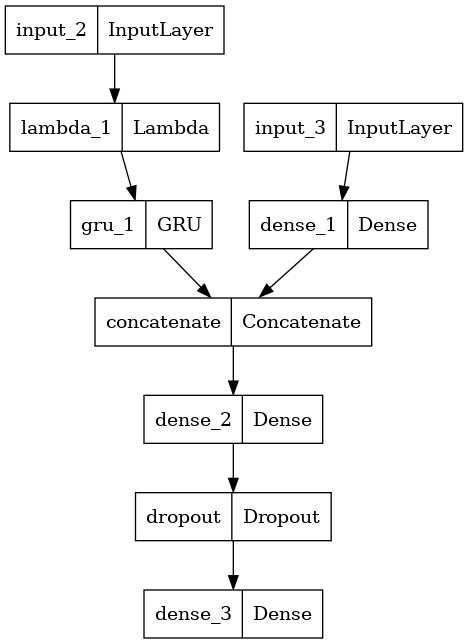

In [45]:
tf.keras.utils.plot_model(model_3)

In [46]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
X_cat_encoder = OrdinalEncoder(categories = [DAYS_OF_WEEK, MONTH_NAMES])
X_cat_encoded = X_cat_encoder.fit_transform(dataset2_cat_features)
X_cat_encoded, X_cat_encoder.categories_

(array([[2., 8.],
        [3., 8.],
        [4., 8.],
        ...,
        [1., 0.],
        [2., 0.],
        [3., 0.]]),
 [array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
         'Sunday'], dtype=object),
  array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
         'August', 'September', 'October', 'November', 'December'],
        dtype=object)])

Epoch 1/5
61/61 [==============================] - 3s 7ms/step - loss: 232.3113
Epoch 2/5
61/61 [==============================] - 0s 7ms/step - loss: 105.8665
Epoch 3/5
61/61 [==============================] - 0s 7ms/step - loss: 90.6746
Epoch 4/5
61/61 [==============================] - 0s 7ms/step - loss: 82.1568
Epoch 5/5
61/61 [==============================] - 0s 7ms/step - loss: 80.3541


<Axes: >

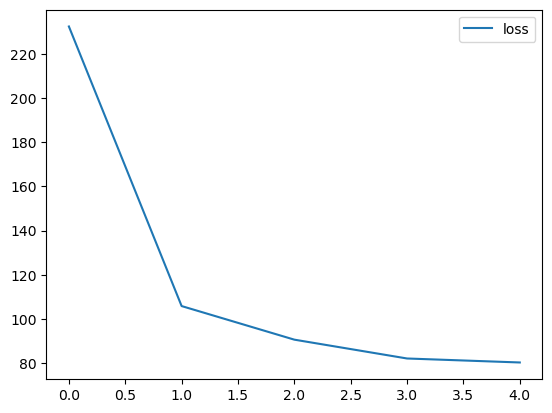

In [47]:
from tensorflow.data import Dataset

model3_history = model_3.fit(x=[dataset2_rv_history_features, X_cat_encoded], y=train_dataset2, epochs=5)
pd.DataFrame(model3_history.history).plot()

In [48]:
test_dataset2 = windowize_dataset(whole_dataset[TEST_DATA_BOUNDARY_INDEX-WINDOW_SIZE:].copy())
test_dataset2['Month.Name'] = pd.Series(test_dataset2.index, index=test_dataset2.index)\
                        .apply(lambda x: calendar.month_name[x.month])
test_dataset2 = test_dataset2.dropna()
test_dataset2

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Returning.Visits[t-1],Returning.Visits[t-2],Returning.Visits[t-3],Month.Name
Date,,,,,,,,,,,
2020-01-16,1951,Thursday,5,3817,2951,2510,441,394.0,434.0,515.0,January
2020-01-17,1952,Friday,6,3175,2419,2006,413,441.0,394.0,434.0,January
2020-01-18,1953,Saturday,7,2336,1927,1681,246,413.0,441.0,394.0,January
2020-01-19,1954,Sunday,1,2597,2031,1717,314,246.0,413.0,441.0,January
2020-01-20,1955,Monday,2,3715,2948,2505,443,314.0,246.0,413.0,January
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,2163,Saturday,7,2221,1696,1373,323,386.0,458.0,427.0,August
2020-08-16,2164,Sunday,1,2724,2037,1686,351,323.0,386.0,458.0,August
2020-08-17,2165,Monday,2,3456,2638,2181,457,351.0,323.0,386.0,August


In [49]:
X_test_rv_history_input = test_dataset2[rv_cols]
X_test_rv_history_input

,Returning.Visits[t-1],Returning.Visits[t-2],Returning.Visits[t-3]
Date,,,
2020-01-16,394.0,434.0,515.0
2020-01-17,441.0,394.0,434.0
2020-01-18,413.0,441.0,394.0
2020-01-19,246.0,413.0,441.0
2020-01-20,314.0,246.0,413.0
...,...,...,...
2020-08-15,386.0,458.0,427.0
2020-08-16,323.0,386.0,458.0
2020-08-17,351.0,323.0,386.0


In [50]:
X_test_cat_input = test_dataset2[['Day', 'Month.Name']]
X_test_cat_input = X_cat_encoder.transform(X_test_cat_input) 
X_test_cat_input.shape, X_test_cat_input[:5]

((217, 2),
 array([[3., 0.],
        [4., 0.],
        [5., 0.],
        [6., 0.],
        [0., 0.]]))

In [51]:
model_3_preds = model_3.predict([X_test_rv_history_input, X_test_cat_input])
model_3_preds[:15]

7/7 [==============================] - 0s 2ms/step


array([[279.64078],
       [386.01538],
       [343.29727],
       [196.14137],
       [457.3244 ],
       [442.8204 ],
       [460.5527 ],
       [410.42392],
       [426.60645],
       [234.8754 ],
       [310.12753],
       [368.60004],
       [472.63535],
       [480.04633],
       [453.04245]], dtype=float32)

In [52]:
y_dataset = test_dataset2['Returning.Visits']
y_dataset

Date
2020-01-16    441
2020-01-17    413
2020-01-18    246
2020-01-19    314
2020-01-20    443
             ... 
2020-08-15    323
2020-08-16    351
2020-08-17    457
2020-08-18    499
2020-08-19    267
Name: Returning.Visits, Length: 217, dtype: int64

{'mae': 72.46600053497174,
 'mse': 8797.218902262757,
 'rmse': 93.79349072437147,
 'mape': 0.15300125677432075}

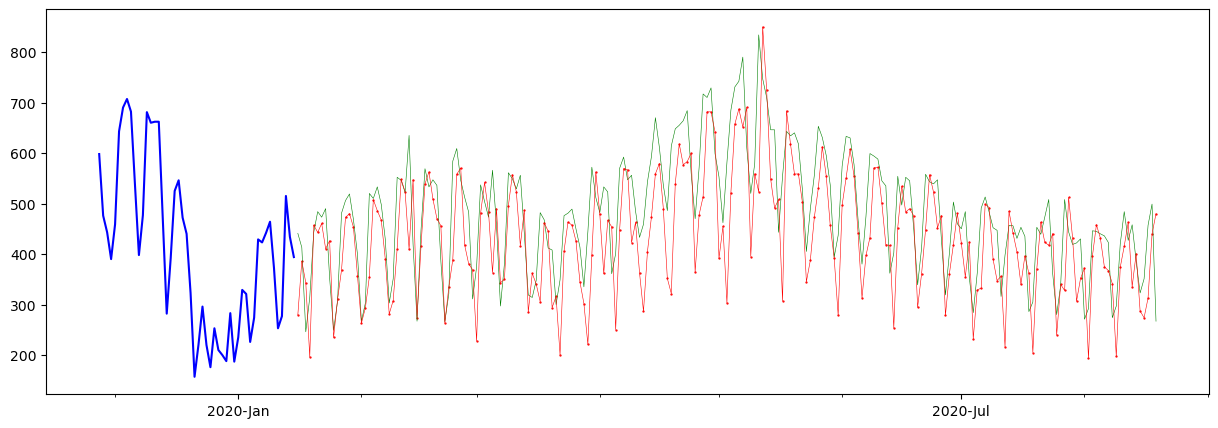

In [53]:
def evaluate_model_predictions(y_true, predictions, model_name):
    metrics = evaluate_predictions(y_true, predictions)
    
    MODEL_METRICS.loc[model_name] = metrics
    plot_time_series(predictions.ravel(), start_index=1900)
    return metrics

evaluate_model_predictions(y_dataset, model_3_preds, 'model_3 (multi-input)')

In [54]:
MODEL_METRICS

,mae,mse,rmse,mape
model_0,72.198157,8508.622120,92.242193,0.167139
model_1,75.977361,9384.529501,96.873781,0.168599
model_3 (multi-input),72.466001,8797.218902,93.793491,0.153001


# Model 4: Ensemble methods

In [55]:
def build_model_5(n_models, loss_fns):
    models = []
    for loss_fn in loss_fns:
        print(f"Training {n_models} models for {loss_fn} loss...")
        for i in range(n_models):
            model = Sequential([
                Input(shape=(WINDOW_SIZE,)),
                Lambda(lambda x: tf.expand_dims(x, axis=1)),
                GRU(128, activation='relu'),
                Dense(1, activation='linear')
            ])
            
            model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Adam())
            models.append(model)
            
    
    return models


model_5 = build_model_5(n_models=5, loss_fns=['mae', 'mse', 'mape'])
model_5

Training 5 models for mae loss...
Training 5 models for mse loss...
Training 5 models for mape loss...


In [56]:
model_5[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 3)              0         
                                                                 
 gru_2 (GRU)                 (None, 128)               51072     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_________________________________________________________________


In [57]:
for i, model in enumerate(model_5):
    print(f"Training model {i+1} out of {len(model_5)} models")
    model.fit(train_dataset, epochs=5, verbose=0)

Training model 1 out of 15 models
Training model 2 out of 15 models
Training model 3 out of 15 models
Training model 4 out of 15 models
Training model 5 out of 15 models
Training model 6 out of 15 models
Training model 7 out of 15 models
Training model 8 out of 15 models
Training model 9 out of 15 models
Training model 10 out of 15 models
Training model 11 out of 15 models
Training model 12 out of 15 models
Training model 13 out of 15 models
Training model 14 out of 15 models
Training model 15 out of 15 models


In [58]:
def ensemble_prediction(models):
    predictions = []
    for model in models:
        pred = model.predict(test_dataset, verbose=0)
        predictions.append(pred)
    
    return np.array(predictions)

model_5_all_preds = ensemble_prediction(model_5)
model_5_all_preds.shape

(15, 217, 1)

In [59]:
model_5_all_preds.shape

(15, 217, 1)

In [60]:
def aggregate_ensemble_predictions(predictions):
    return tf.reduce_mean(predictions, axis=0).numpy()

model_5_preds = aggregate_ensemble_predictions(model_5_all_preds)
model_5_preds.shape

(217, 1)

{'mae': 76.4167720952891,
 'mse': 9269.116805046226,
 'rmse': 96.27625254986935,
 'mape': 0.16783678586900533}

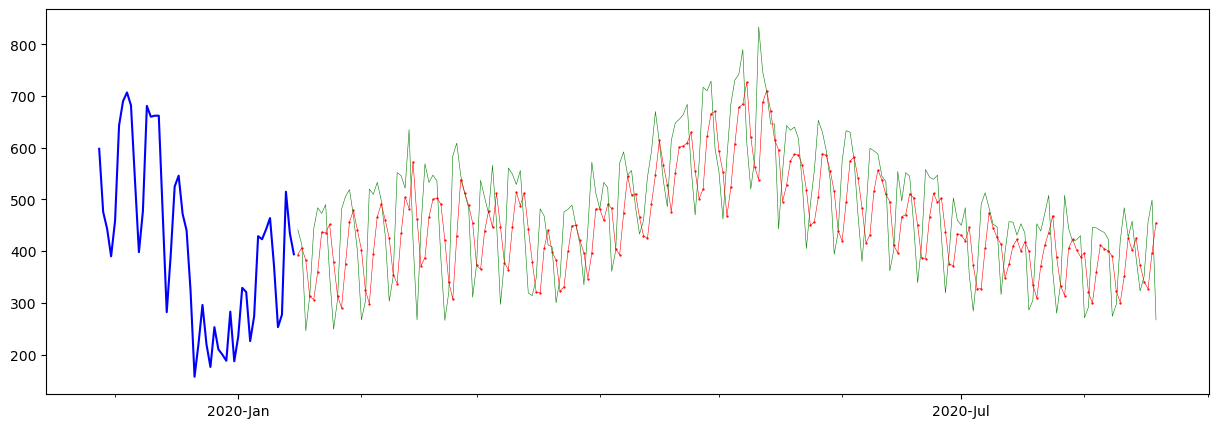

In [61]:
evaluate_model_predictions(y_true, model_5_preds, 'model_5 (ensemble)')

In [62]:
MODEL_METRICS

,mae,mse,rmse,mape
model_0,72.198157,8508.622120,92.242193,0.167139
model_1,75.977361,9384.529501,96.873781,0.168599
model_3 (multi-input),72.466001,8797.218902,93.793491,0.153001
model_5 (ensemble),76.416772,9269.116805,96.276253,0.167837
